## Introduction

Here we are giving a brief introduction to rasterizing shapefiles by rasterizing country ids into a given grid.

In [1]:
import pyogrio as pio
import xarray as xr

import ptolemy as pt

## Data

We generally begin with gridded data that we want our future raster to look like. Let's take an example from `xarray` looking at some data over North America.

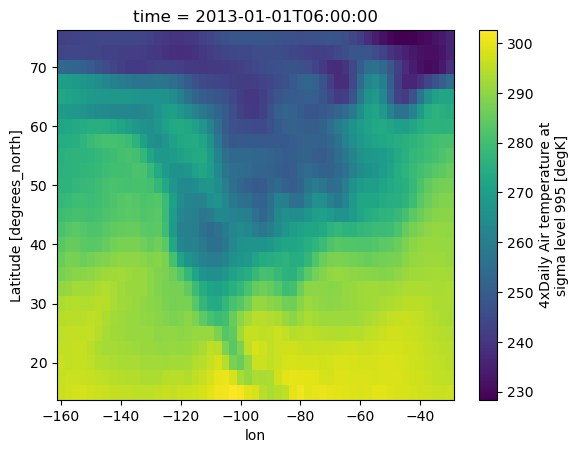

In [2]:
ds = xr.tutorial.load_dataset("air_temperature")
ds["lon"] = ds.lon - 360  # change from degrees_east to centered at prime meridian
grid = ds.air.isel(time=1)
grid.plot()

We can then pull out a shapefile dataset for country borders

In [3]:
url = "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_0_countries.geojson"

(-90.0, 90.0)

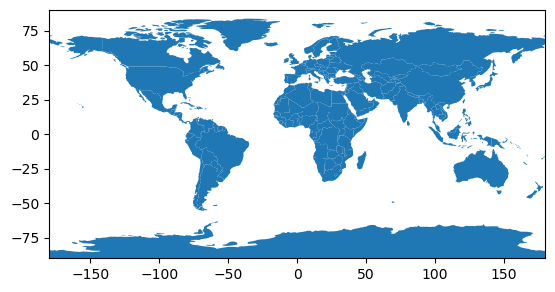

In [5]:
# let's take a look
ax = pio.read_dataframe(url).plot()
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

## Rasterize with Ptolemy

The basic steps are to great a `Rasterize` object, tell it what shapefile you want to rasterize, and what strategy you want to use to do the rasterization.

Because `ptolemy` is built on excellent packages like `rasterio` which link into `GDAL`, we get some basic rasterization approaches for 'free' - these are basically just pass throughs to the [`gdal_rasterize`](https://gdal.org/programs/gdal_rasterize.html) functions and include

- `centroid`: each pixel is assigned the shape element which overlaps its center
- `all_touched`: all pixels touched by shape elements are assigned those elements, depends on the order shape elements are assessed

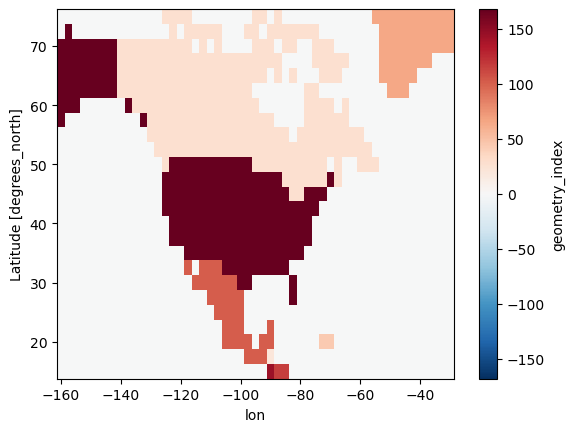

In [6]:
r = pt.Rasterize(like=grid)
r.read_shpf(url, idxkey="iso_a3")
idxr_c = r.rasterize(strategy="centroid", verbose=True)
idxr_c.plot()  # idxr_c is an xr.DataArray

We can also use an 'all-touched' approach

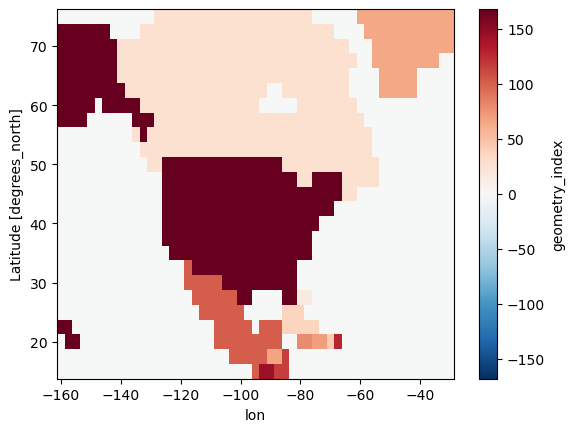

In [7]:
r = pt.Rasterize(like=grid)
r.read_shpf(url, idxkey="iso_a3")
idxr_at = r.rasterize(strategy="all_touched", verbose=True)
idxr_at.plot()

and see the differences

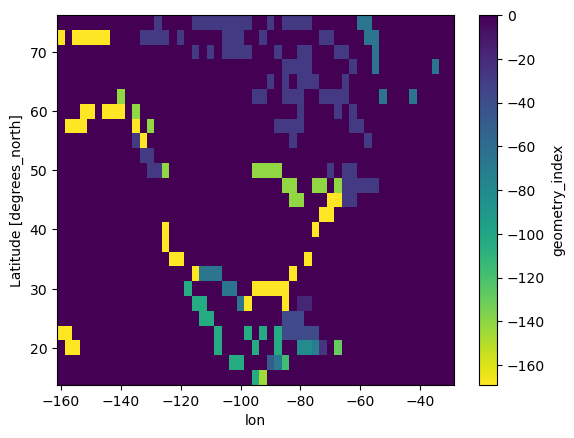

In [8]:
(idxr_c - idxr_at).plot(cmap="viridis_r")

## Advanced Rasterization Approaches


### Hybrid

The `hybrid` approach tries to get the best of both worlds from `centroid` and `all_touched`. It performs both rasterizations, preferring centroids, but then filling in missing cells from the all touched approach.

By implementation, it does the following

```
mask_hybrid = mask_centroid + np.where(mask_centroid == 0, mask_all_touched, 0)
```

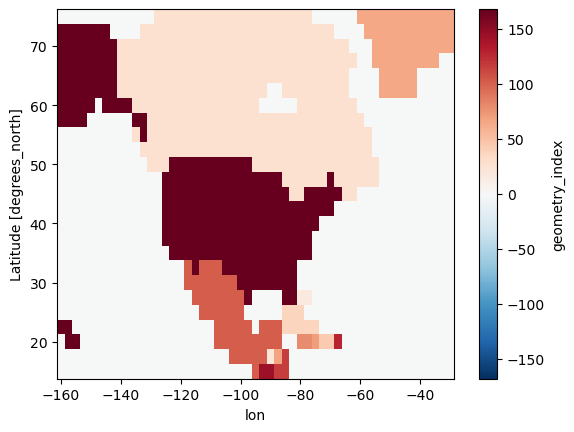

In [9]:
r = pt.Rasterize(like=grid)
r.read_shpf(url, idxkey="iso_a3")
idxr_h = r.rasterize(strategy="hybrid", verbose=True)
idxr_h.plot()

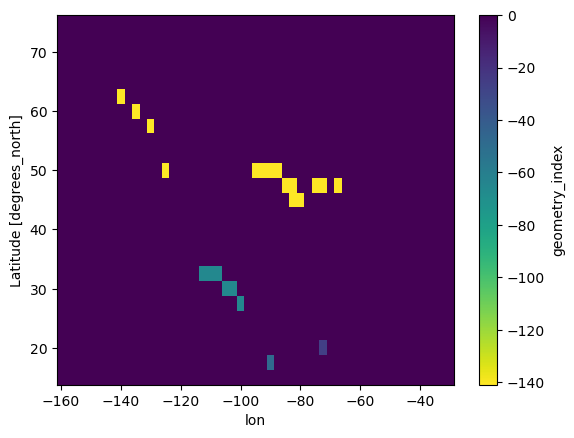

In [10]:
(idxr_h - idxr_at).plot(cmap="viridis_r")

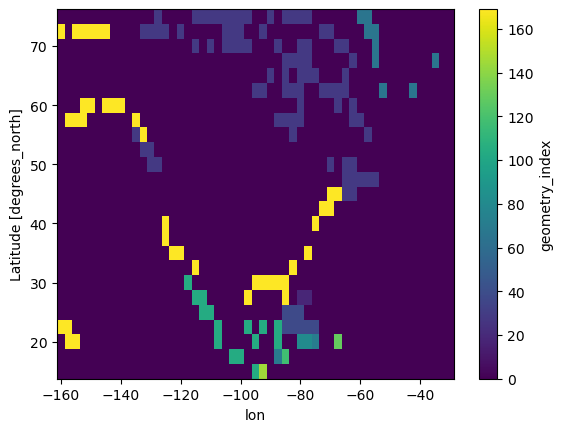

In [11]:
(idxr_h - idxr_c).plot()

### Majority

Sometimes one or more shapes overlap into the same grid cell. `ptolemy` offers methods to calculate which shape has the largest proportion of the cell and assign the cell that shape value. Notice in the below map that the country borders are 'clean'.

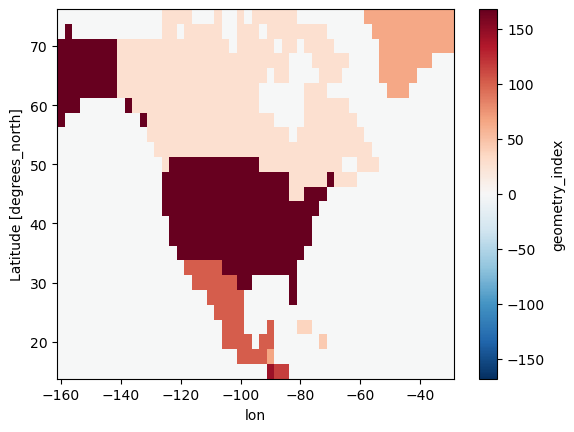

In [12]:
r = pt.Rasterize(like=grid)
r.read_shpf(url, idxkey="iso_a3")
idxr_m = r.rasterize(strategy="majority", verbose=True)
idxr_m.plot()

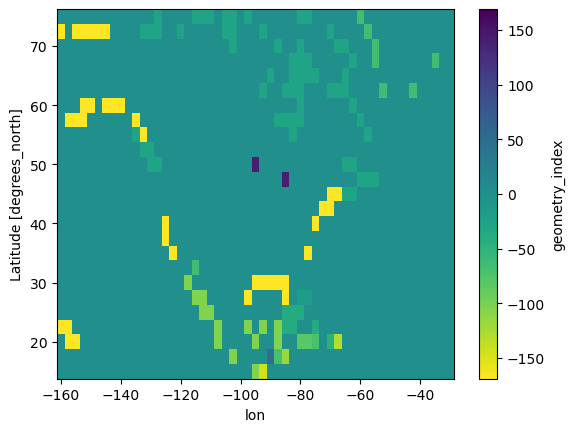

In [13]:
(idxr_m - idxr_h).plot(cmap="viridis_r")

It can be the case that empty area takes up the most space of a cell, but we still want to assign that to a shape with data. We have a method for that!

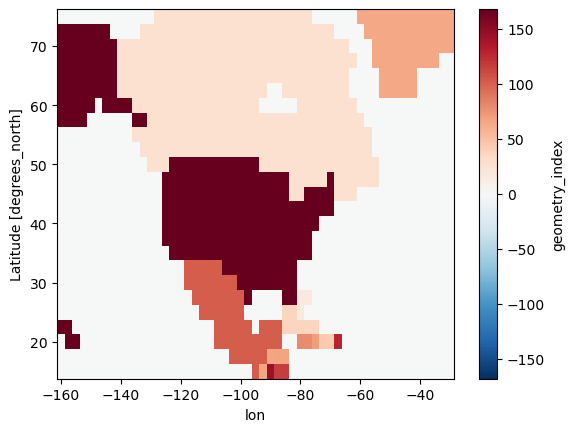

In [14]:
r = pt.Rasterize(like=grid)
r.read_shpf(url, idxkey="iso_a3")
idxr_m_ignore = r.rasterize(strategy="majority_ignore_nodata", verbose=True)
idxr_m_ignore.plot()

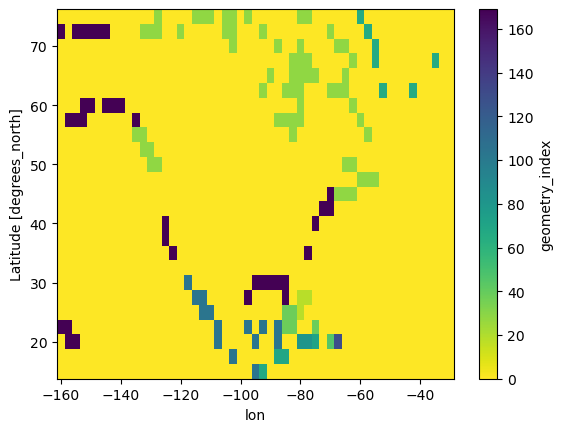

In [15]:
(idxr_m_ignore - idxr_m).plot(cmap="viridis_r")

### Percent of area rasters

The final approach we have is to simply tell you the fraction of area in each grid cell taken up by a shape as rasterized. This produces a much larger array, since it includes a new dimension with size `N_shapes`.

In [16]:
r = pt.Rasterize(like=grid)
r.read_shpf(url, idxkey="iso_a3")
idxr_w = r.rasterize(strategy="weighted")

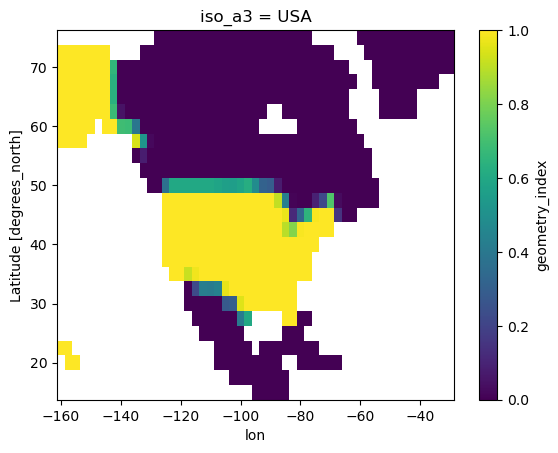

In [18]:
idxr_w.sel(iso_a3="USA").plot()

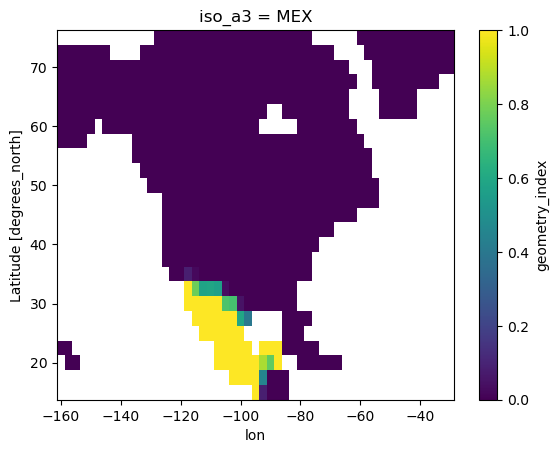

In [19]:
idxr_w.sel(iso_a3="MEX").plot()